In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from category_encoders import OneHotEncoder, BinaryEncoder
from sklearn.preprocessing import LabelEncoder, RobustScaler, MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import SGDClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier


In [2]:
# Đọc dữ liệu từ file CSV
matches_df = pd.read_csv("../../../data_for_training/arsenal.csv")

In [3]:
# Chọn các tính năng và loại bỏ biến mục tiêu nếu nó đã được bao gồm trong dữ liệu
X = matches_df.drop(['result'], axis=1)

## Chuẩn Hóa Dữ Liệu

In [4]:
# Xác định các cột phân loại và cột số
categorical_cols = ['venue', 'season']
numerical_cols = [col for col in X if col not in categorical_cols]

In [5]:
# Định nghĩa các cột số và scaler tương ứng
std_numerical_cols = [
    "average_score_before_match_team2",
]

min_max_numerical_cols = [
    "win_percent_before_team2",
    "lose_percent_before_team2",
    "head2head_win_percent",
    "head2head_draw_percent",
    "head2head_lost_percent",
]

robust_numerical_cols = [
    "win_percent_diff",
    "ELO_before_match_team2",
    "ELO_before_diff",
]

In [6]:
preprocessor = ColumnTransformer(
    transformers=[
        ("venue", OneHotEncoder(), ["venue"]),
        ("season", BinaryEncoder(), ["season"]),
        ('num_std', StandardScaler(), std_numerical_cols),
        ('num_minmax', MinMaxScaler(), min_max_numerical_cols),
        ('num_robust', RobustScaler(), robust_numerical_cols),
    ],
    remainder='passthrough'
)

# Fit và transform
X_transformed = preprocessor.fit_transform(X)

# Construct the new column names list
transformed_columns = []
for name, transformer, column in preprocessor.transformers_[:-1]:
    if hasattr(transformer, 'get_feature_names_out'):
        transformed_columns.extend(transformer.get_feature_names_out(column))
    else:
        transformed_columns.extend(column)


print(transformed_columns)

['venue_1', 'venue_2', 'season_0', 'season_1', 'season_2', 'season_3', 'season_4', 'average_score_before_match_team2', 'win_percent_before_team2', 'lose_percent_before_team2', 'head2head_win_percent', 'head2head_draw_percent', 'head2head_lost_percent', 'win_percent_diff', 'ELO_before_match_team2', 'ELO_before_diff']


In [7]:
# Include the columns that are passed through untouched
passthrough_columns = [col for col in X.columns if col not in sum((list(map) for _, _, map in preprocessor.transformers_[:-1]), [])]
transformed_columns.extend(passthrough_columns)

# Tạo DataFrame mới
X_transformed = pd.DataFrame(X_transformed, columns=transformed_columns, index=X.index)
X_transformed = X_transformed.rename(columns={
    'venue_1': 'venue_Away',
    'venue_2': 'venue_Home'
})
X_transformed = X_transformed[[
    'venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2', 'season_3',
    'season_4', 'win_percent_before_team2', 'win_percent_diff',
    'lose_percent_before_team2', 'head2head_win_percent',
    'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
    'ELO_before_match_team2', 'ELO_before_diff', 'average_score_before_match_team2'
]]
X_transformed

,venue_Away,venue_Home,season_0,season_1,season_2,season_3,season_4,win_percent_before_team2,win_percent_diff,lose_percent_before_team2,head2head_win_percent,head2head_draw_percent,head2head_lost_percent,is_opponent_big6,ELO_before_match_team2,ELO_before_diff,average_score_before_match_team2
0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.000000,-5.000000e-01,0.000000,0.000000,0.000000,0.000000,0.0,0.096287,-0.485577,-1.807943
1,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,-3.000000e+00,0.000000,0.000000,0.000000,0.000000,1.0,0.228867,-0.631132,2.241178
2,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.500000,-5.000000e-01,0.500000,0.000000,0.000000,0.000000,0.0,0.153755,-0.487024,0.216618
3,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.333333,3.333333e-01,0.333333,0.000000,0.000000,0.000000,1.0,0.129600,-0.386275,-0.008334
4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.250000,1.250000e-01,0.500000,0.000000,0.000000,0.000000,0.0,-0.087895,-0.259775,-0.458236
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.400000,-1.000000e+00,0.200000,0.900000,0.000000,0.100000,0.0,-1.134746,0.483388,0.351588
795,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.400000,-5.000000e-01,0.200000,0.700000,0.100000,0.200000,0.0,-2.004035,1.120644,0.351588
796,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.800000,-1.000000e+00,0.000000,0.300000,0.400000,0.300000,1.0,1.753349,-0.938677,1.701296
797,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.400000,-2.775558e-16,0.600000,0.300000,0.500000,0.200000,0.0,-0.506261,0.337509,-0.188295


In [9]:
X_dbscan = X_transformed.copy()

### Áp dụng kmeans

#### Trực quan hóa

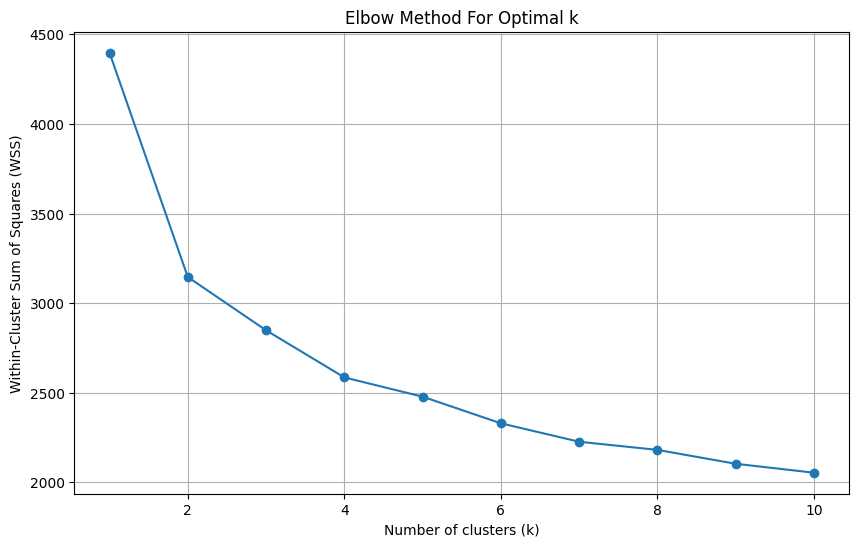

In [29]:
# Tính WSS cho một phạm vi số cụm từ 1 đến 10
wss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, random_state=42)
    kmeans.fit(X_transformed)
    wss.append(kmeans.inertia_)  # inertia_ là thuộc tính chứa tổng bình phương khoảng cách

# Vẽ đồ thị Elbow
plt.figure(figsize=(10, 6))
plt.plot(range(1, 11), wss, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters (k)')
plt.ylabel('Within-Cluster Sum of Squares (WSS)')
plt.grid(True)
plt.show()

In [30]:
import pickle
# Chọn số lượng cụm
k = 3  # Có thể thay đổi số này sau khi phân tích (ví dụ: sử dụng phương pháp Elbow)

# Phân cụm
kmeans = KMeans(n_clusters=k, random_state=42)
X_transformed['Cluster'] = kmeans.fit_predict(X_transformed)


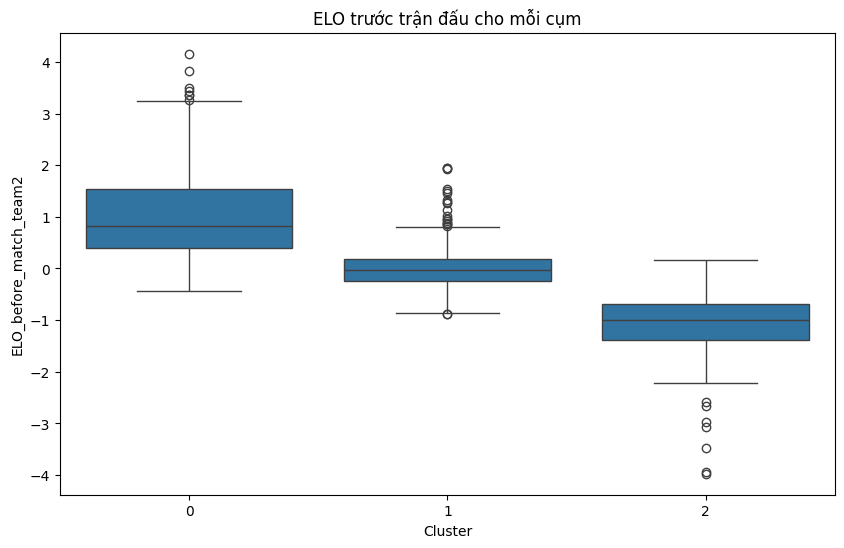

F-value: 18043.78067783859 P-value: 0.0


In [31]:
# Biểu đồ hộp cho biến 'ELO_before_match_team2'
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y='ELO_before_match_team2', data=X_transformed)
plt.title('ELO trước trận đấu cho mỗi cụm')
plt.show()

# Kiểm định ANOVA cho biến 'ELO_before_match_team2' để xem sự khác biệt giữa các cụm
import scipy.stats as stats

f_value, p_value = stats.f_oneway(matches_df[X_transformed['Cluster'] == 0]['ELO_before_match_team2'],
                                  X_transformed[X_transformed['Cluster'] == 1]['ELO_before_match_team2'],
                                  X_transformed[X_transformed['Cluster'] == 2]['ELO_before_match_team2'])
print('F-value:', f_value, 'P-value:', p_value)


- Cụm 0: Đối Thủ Mạnh
- Cụm 1: Đối Thủ Trung Bình
- Cụm 2: Đối Thủ Yếu

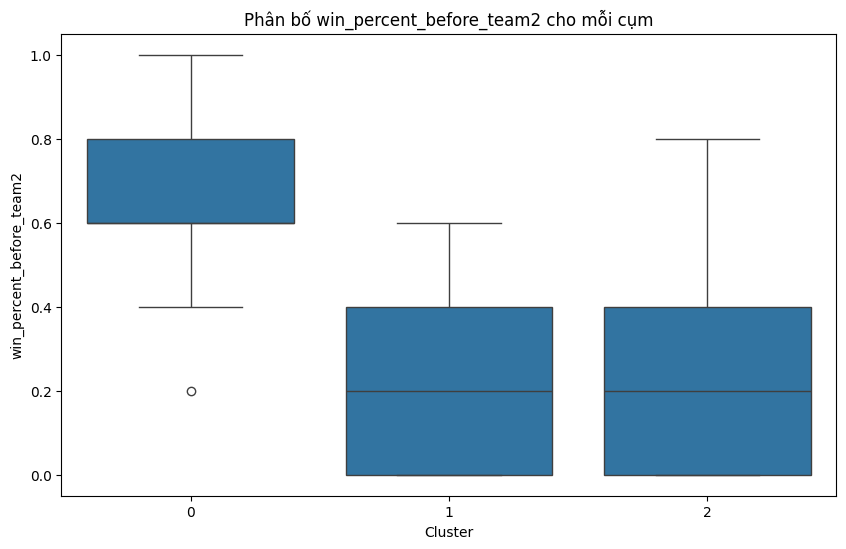

F-Value: 525.2373369074522, P-Value: 3.620308387164661e-146


In [32]:
# Chọn một biến để trực quan hóa
variable = 'win_percent_before_team2'  # Ví dụ: tỷ lệ thắng trước trận

# Biểu đồ hộp cho biến được chọn
plt.figure(figsize=(10, 6))
sns.boxplot(x='Cluster', y=variable, data=X_transformed)
plt.title(f'Phân bố {variable} cho mỗi cụm')
plt.show()

# ANOVA test
import scipy.stats as stats
f_val, p_val = stats.f_oneway(X_transformed[X_transformed['Cluster'] == 0][variable],
                              X_transformed[X_transformed['Cluster'] == 1][variable],
                              X_transformed[X_transformed['Cluster'] == 2][variable])
print(f'F-Value: {f_val}, P-Value: {p_val}')


- Cụm 0: Đội có tỷ lệ thắng cao
- Cụm 1: Đội có tỷ lệ thắng thấp
- Cụm 2: Đội có tỷ lệ thắng trung bình

#### Vẽ cụm theo không gian 2 chiều

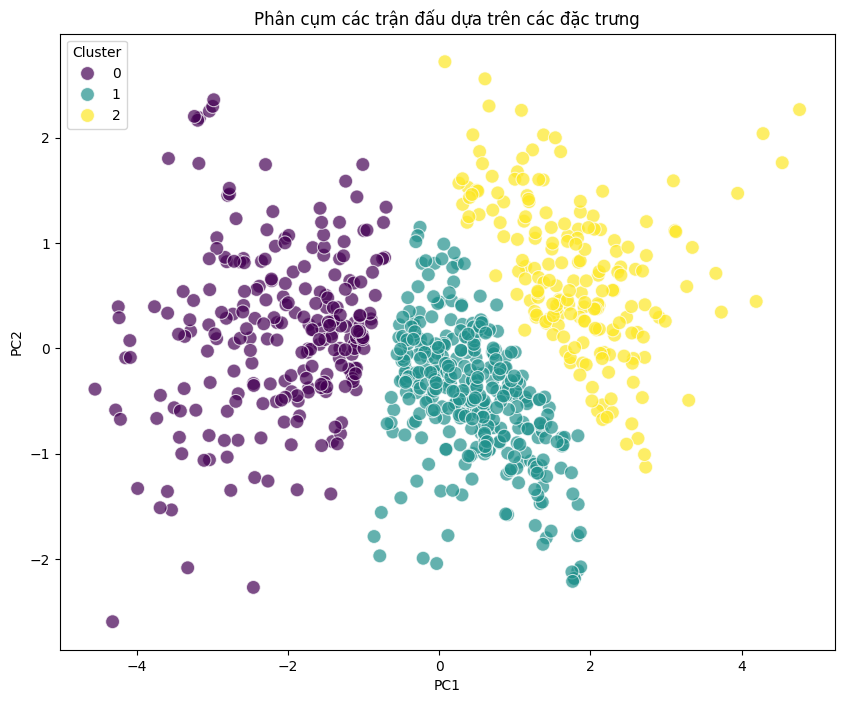

In [33]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns

# Giảm chiều dữ liệu xuống 2D để trực quan hóa
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_transformed)

# Tạo DataFrame cho việc trực quan hóa
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = X_transformed['Cluster']

# Vẽ biểu đồ
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, s=100)
plt.title('Phân cụm các trận đấu dựa trên các đặc trưng')
plt.show()


#### Gán nhãn cho từng cụm

In [34]:
# Gán nhãn cho từng cụm
def assign_cluster_label(cluster):
    if cluster == 0:
        return 'Strong Opponent'
    elif cluster == 1:
        return 'Weak Opponent'
    elif cluster == 2:
        return 'Average Opponent'
    else:
        return 'Unknown'

# Thêm cột match_type vào DataFrame
X_transformed['match_type'] = X_transformed['Cluster'].apply(assign_cluster_label)

# Kiểm tra kết quả
print(X_transformed[['Cluster', 'match_type']].head())


   Cluster       match_type
0        1    Weak Opponent
1        0  Strong Opponent
2        1    Weak Opponent
3        1    Weak Opponent
4        1    Weak Opponent


In [35]:
# Gán nhãn tỷ lệ thắng cho từng cụm
def assign_win_label(cluster):
    if cluster == 0:
        return 'High Win Rate'
    elif cluster == 1:
        return 'Low Win Rate'
    elif cluster == 2:
        return 'Average Win Rate'
    else:
        return 'Unknown'

# Thêm cột win_rate_type vào DataFrame
X_transformed['win_rate_type'] = X_transformed['Cluster'].apply(assign_win_label)

# Kiểm tra kết quả
print(X_transformed[['Cluster', 'match_type', 'win_rate_type']].head())

   Cluster       match_type  win_rate_type
0        1    Weak Opponent   Low Win Rate
1        0  Strong Opponent  High Win Rate
2        1    Weak Opponent   Low Win Rate
3        1    Weak Opponent   Low Win Rate
4        1    Weak Opponent   Low Win Rate


In [38]:
import pickle
with open("../../train_model/Arsenal/final_model_clustered/kmeans_model.pkl", "wb") as file:
    pickle.dump(kmeans, file)

### Áp dụng DBSCAN

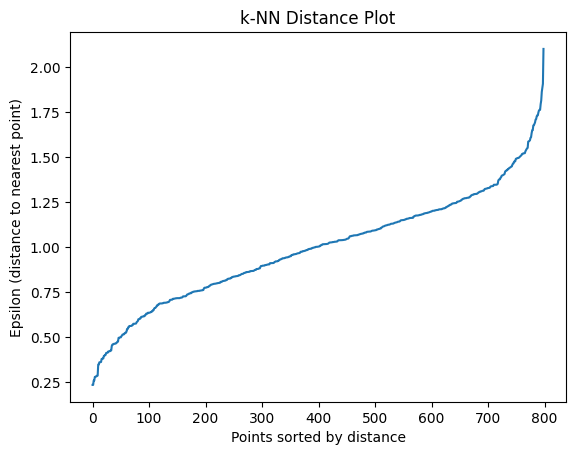

In [11]:
from sklearn.neighbors import NearestNeighbors
# Sử dụng NearestNeighbors để tìm khoảng cách tới điểm láng giềng gần nhất
neigh = NearestNeighbors(n_neighbors=2)
nbrs = neigh.fit(X_dbscan)
distances, indices = nbrs.kneighbors(X_dbscan)

# Sắp xếp và trực quan hóa các khoảng cách
distances = np.sort(distances, axis=0)
distances = distances[:,1]
plt.plot(distances)
plt.title('k-NN Distance Plot')
plt.xlabel('Points sorted by distance')
plt.ylabel('Epsilon (distance to nearest point)')
plt.show()

In [18]:
X_dbscan.columns

Index(['venue_Away', 'venue_Home', 'season_0', 'season_1', 'season_2',
       'season_3', 'season_4', 'win_percent_before_team2', 'win_percent_diff',
       'lose_percent_before_team2', 'head2head_win_percent',
       'head2head_draw_percent', 'head2head_lost_percent', 'is_opponent_big6',
       'ELO_before_match_team2', 'ELO_before_diff',
       'average_score_before_match_team2', 'Cluster'],
      dtype='object')

Đường cong bắt  đầu đột biến tại khoảng 1.5 -> 1.75

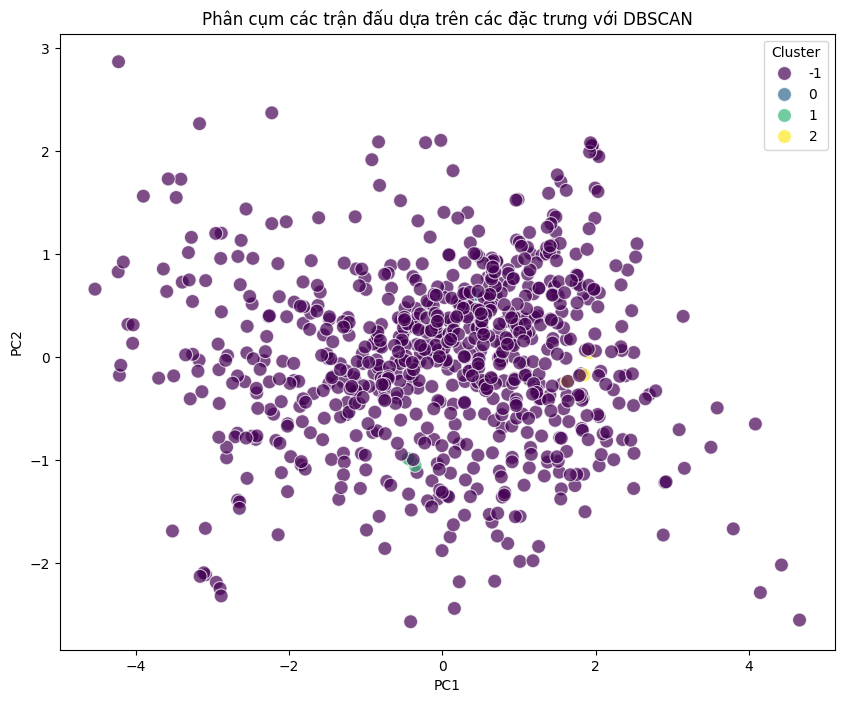

In [25]:
# Thử điều chỉnh các tham số
eps_values = np.linspace(0.5, 2.0, 10)  # Tạo một dải giá trị cho eps để thử nghiệm
min_samples_values = range(2, 6)  # Thử với các giá trị khác nhau của min_samples

results = []

for eps in eps_values:
    for min_samples in min_samples_values:
        dbscan = DBSCAN(eps=eps, min_samples=min_samples)
        clusters = dbscan.fit_predict(X_dbscan.drop(['Cluster'], axis=1))
        n_clusters = len(set(clusters)) - (1 if -1 in clusters else 0)
        results.append((eps, min_samples, n_clusters))

# Chọn cặp tham số với kết quả mong muốn gần 3 cụm nhất
results = np.array(results)
desired_clusters = 3
closest = np.argmin(np.abs(results[:, 2] - desired_clusters))
best_eps, best_min_samples, _ = results[closest]

# Áp dụng DBSCAN với các tham số tốt nhất tìm được
dbscan = DBSCAN(eps=best_eps, min_samples=int(best_min_samples))
clusters = dbscan.fit_predict(X_dbscan.drop(['Cluster'], axis=1))
X_dbscan['Cluster'] = clusters

# Thực hiện PCA để trực quan hóa kết quả
pca = PCA(n_components=2)
principal_components = pca.fit_transform(X_dbscan.drop('Cluster', axis=1))
pca_df = pd.DataFrame(data=principal_components, columns=['PC1', 'PC2'])
pca_df['Cluster'] = clusters

# Trực quan hóa kết quả bằng biểu đồ phân tán
plt.figure(figsize=(10, 8))
sns.scatterplot(x='PC1', y='PC2', hue='Cluster', data=pca_df, palette='viridis', alpha=0.7, s=100)
plt.title('Phân cụm các trận đấu dựa trên các đặc trưng với DBSCAN')
plt.show()

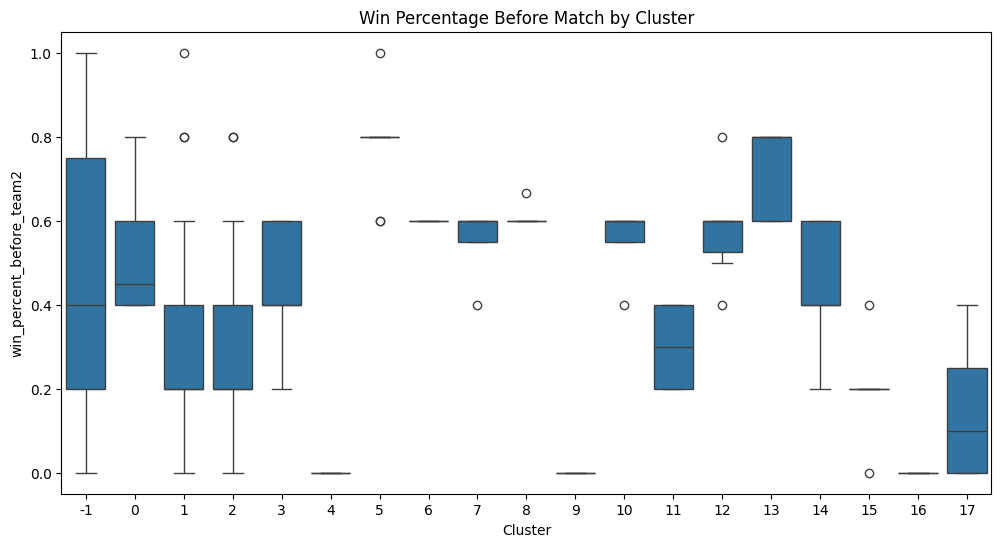

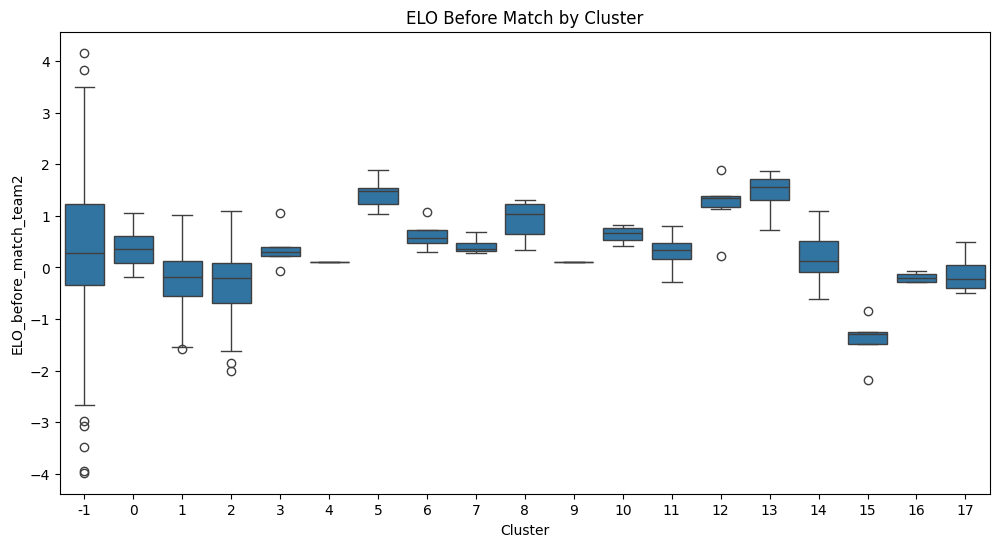

In [21]:
import seaborn as sns
import matplotlib.pyplot as plt

# Biểu đồ Boxplot cho 'win_percent_before_team2' theo cụm
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='win_percent_before_team2', data=X_dbscan)
plt.title('Win Percentage Before Match by Cluster')
plt.show()

# Biểu đồ Boxplot cho 'ELO_before_match_team2' theo cụm
plt.figure(figsize=(12, 6))
sns.boxplot(x='Cluster', y='ELO_before_match_team2', data=X_dbscan)
plt.title('ELO Before Match by Cluster')
plt.show()
